Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib
med in binning(): 6.73473729241e+21


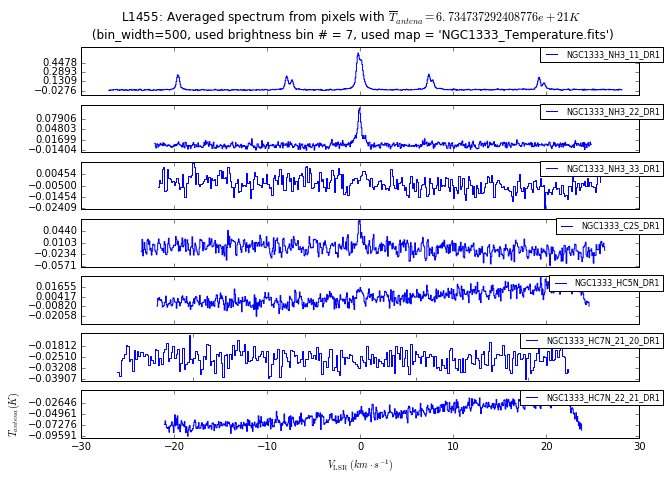

med in binning(): 7.42259302815e+22
med in binning(): 2.86285629769e+22
med in binning(): 1.599787156e+22
med in binning(): 1.23169404654e+22
med in binning(): 1.01853459383e+22
med in binning(): 8.61964092584e+21
med in binning(): 7.5445396335e+21


map,bin width,bin#,T_med,H3,H3_22,H3_33,2S,HC5N,HC7N_21_20,HC7N_22_2
str30,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
NGC1333_Temperature.fits,500.0,0.0,7.42259302815e+22,4.51721712958,1.20038799016,0.339639575096,0.353340062411,0.0628027874567,-0.728472120563,-0.478612812951
NGC1333_Temperature.fits,500.0,1.0,2.86285629769e+22,2.94583508717,0.701744422069,0.0818295412638,0.115704899482,0.0236592985376,-0.411395385388,-0.341374610883
NGC1333_Temperature.fits,500.0,2.0,1.599787156e+22,1.4907328211,0.324593766936,0.0298039866106,0.056271351965,0.0162636401982,-0.245326137097,-0.345386652454
NGC1333_Temperature.fits,500.0,3.0,1.23169404654e+22,1.13944662187,0.216325389041,-0.00108821521546,0.0663623374804,0.0169560784434,-0.205783776734,-0.331326973576
NGC1333_Temperature.fits,500.0,4.0,1.01853459383e+22,0.90790313745,0.151555257776,-0.00671971599002,0.0434967845164,0.0185101914693,-0.155526892704,-0.276750109888
NGC1333_Temperature.fits,500.0,5.0,8.61964092584e+21,0.739554707322,0.102441252687,-0.0117354518238,0.0221390495443,0.0148527073792,-0.135537566304,-0.233539241613
NGC1333_Temperature.fits,500.0,6.0,7.5445396335e+21,0.604760958986,0.0832898695796,-0.00547108894051,0.0245563126574,0.00470104661216,-0.118337060397,-0.23626816004


In [9]:
# What are the variables we want set as default?
# Taking out the user input leaves much less comparison options? what do we want to compare actually?
# Now bin_width=500, wanted_bin=0 occure as kew words in main() and in binning() function. Is this OK?
# Do we want to have global variable declarations in the header?


import GAS
from spectral_cube import SpectralCube
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd
import astropy.units as u
from astropy.io import fits
from astropy.table import Table

%pylab
%matplotlib inline

vlsr = fits.getdata('NGC1333_Vlsr_v1.fits')
files =['NGC1333_NH3_11_DR1.fits', 'NGC1333_NH3_22_DR1.fits', 'NGC1333_NH3_33_DR1.fits', 
       'NGC1333_C2S_DR1.fits',
       'NGC1333_HC5N_DR1.fits',
        'NGC1333_HC7N_21_20_DR1.fits', 'NGC1333_HC7N_22_21_DR1.fits']
bin_width = 500
this_bin = 7
map_name = 'NGC1333_Temperature.fits'


def main(this_bin, bin_width):   
    # This is the main routine.
    loop_count = 0
    fig = plt.figure(figsize=(10,7))
    # for plotting plots in a single figure put plt.figure before all the .plot commands
    # otherwise you will get the plots in a different figures
    
    ax1 = plt.subplot(len(files), 1, 1)
    y, x, med = binning(map_name, bin_width, this_bin)
    # This takes in a 2D map and returns a 2D map where the image values are the bin to which a pixel belongs.
    
    for file_name in files:            
        sp_av, cube = averaging(file_name, y, x)
        thiscube_spectrum_dv, cube, offset_velocity = averaging_over_dopplervel(file_name, y, x)
        #Change to velocity axis and such here as well.  Then average all spectra with that bin label.
        ax = fig.add_subplot(len(files),1,loop_count+1)
        plt.plot(offset_velocity,thiscube_spectrum_dv, drawstyle='steps')
        plt.yticks(np.arange(min(thiscube_spectrum_dv), max(thiscube_spectrum_dv), (max(thiscube_spectrum_dv)-min(thiscube_spectrum_dv))/4))     
    
        
        if file_name != files[-1]:
            plt.setp(ax.get_xticklabels(), visible=False)

        file_name = file_name.strip('L1455_').strip('_all.fits')
        plt.legend([file_name], bbox_to_anchor=(1.05, 1.1), prop={'size':8})
        
        loop_count += 1        

#     plt.legend(leg, loc = 5, prop={'size':8})
#     ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
#     fig.legend(curves_names, leg, bbox_to_anchor=(0.5, -0.15))
#     figtext(.1,.0,'averaging over brightness, with doppler v correction, thisbin=2' , fontsize=8)
#     fig.suptitle("averaging over brightness with brightnes bin = %r for bin width = %r" %(this_bin, bin_width), fontsize=12)
    fig.suptitle("L1455: Averaged spectrum from pixels with $\overline{T}_{antena} = %rK$ \n (bin_width=%r, used brightness bin # = %r, used map = %r)"
                 %(med, bin_width, this_bin, map_name), fontsize=12)
    plt.ylabel(r'$T_{antena} (K)$')
    plt.xlabel(r'$V_{\mathrm{LSR}}\ (km \cdot s^{-1})$')
#     plt.savefig("L1455:BinsAveraging_NH3map_bin_width=%rthis_bin=%r.png" %(bin_width, this_bin))
    plt.show()
    t = make_table2(files, map_name, this_bin, bin_width, y, x)
#     table.write('filename.txt', format='latex') # - COOL!!!
#     t.write('NGC1333MaxBin#7.txt', format='ascii.fixed_width')
    return t
    
def binning(f_nam, bin_width, this_bin):
    """A function creating brightness bins of pixels, and eventualy a map, in the given spectral cube"""
#     cube = SpectralCube.read(f_nam)
#     cube = cube.with_spectral_unit(u.km/u.s,velocity_convention='radio')
#     Tmax = cube.apply_numpy_function(np.nanmax,axis=0) # array of the maximum values in the spectra of each pixel
#     baddata = nd.morphology.binary_dilation(np.isnan(Tmax),np.ones((25,25)))
#     Tmax[baddata]=0.0
#     Tmax[np.isfinite(Tmax)]
    
    Tmax = fits.getdata('NGC1333_DustColumn.fits')
    bin_arr = np.sort(Tmax[np.isfinite(Tmax)])
    bin_arr2 = bin_arr[:: - bin_width] # this creates an array of the bin margins, in which every bin has a width of "bin_width"  
    bins = np.digitize(Tmax,bin_arr2)
    y, x = np.where(bins==this_bin)
    med = round(np.median(Tmax[y,x]), 2)
    print 'med in binning():', med
    return y, x, med

def averaging(file_name, y, x):
    cube = SpectralCube.read(file_name)
    cube = cube.with_spectral_unit(u.km/u.s,velocity_convention='radio')
    sp_av = np.nanmean(cube.filled_data[:,y,x].value,axis=1)
    return sp_av, cube

def averaging_over_dopplervel(file_name, y, x):
    cube = SpectralCube.read(file_name)
    cube = cube.with_spectral_unit(u.km/u.s,velocity_convention='radio')
    sp_av = np.nanmean(cube.filled_data[:,y,x].value,axis=1)
    thiscube_spectrum_dv, offset_velocity = GAS.gasBinning.BinByMask(cube, CentroidMap = vlsr, x = x, y = y)
    return thiscube_spectrum_dv, cube, offset_velocity

# def spectral_integral(offset_velocity, thiscube_spectrum_dv):
#     ind = np.abs(offset_velocity) <= 2
#     sp_integral = np.nansum(thiscube_spectrum_dv[ind])
#     return sp_integral

def spectral_integral(offset_velocity, thiscube_spectrum_dv, cube):
    # first, calculating the spectral-bin-width
    spec_bin_w = (cube.spectral_axis[1] - cube.spectral_axis[2])
    ind = np.abs(offset_velocity) <= 2
    # assuming that all spectral-bins have the same width
    sp_integral = np.nansum(thiscube_spectrum_dv[ind]) * spec_bin_w
    return sp_integral.value


def make_table2(files, map_name, this_bin, bin_width, y, x):
    # approach: first loop - make all the columns, with names. First columns will contain all the same data,
    # last ones would be empty.
    # second loop - append all the rows with the data
    
    # Or, create an empty tables. Then create in a loop all the rows. At the end of the loop add the rows
    # to the table. Then just add region, map and bin_width
    # in the title
        
    table_names = ['map', 'bin width', 'bin#', 'T_med'] + [f.strip('NGC1333_').strip('_DR1_all.fits') for f in files]
    arr = np.arange(len(table_names)*this_bin).reshape(this_bin, len(table_names))    
    t = Table(arr, names=table_names, meta={'name': 'table'}, dtype=['S30'] + (len(table_names)-1)*['f8'])    
    for bin_num in range(this_bin):
        y, x, med = binning(map_name, bin_width, bin_num)
        row = [map_name, bin_width, bin_num, med]
        for file_name in files:
            thiscube_spectrum_dv, cube, offset_velocity = averaging_over_dopplervel(file_name, y, x)
            sp_integral = spectral_integral(offset_velocity, thiscube_spectrum_dv, cube)
            row.append(sp_integral)
        t[bin_num] = row

    return t
    

t = main(this_bin, bin_width)
t

In [56]:
?with_spectral_unit

Object `with_spectral_unit` not found.
